In [1]:
import os
import datetime

import sys

sys.path.append("..")
import datetime, time, os

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf


from sklearn.preprocessing import StandardScaler, MinMaxScaler
from functions import df_security_code

import tensorflow as tf

from tensorflow import keras
#from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

mpl.rcParams['figure.figsize'] = (5, 5)
mpl.rcParams['axes.grid'] = False
# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

# Data

In [2]:
data = pd.read_csv('../data/curr_price_financial_fill.csv', parse_dates=['Date'],  index_col=[0])
df = df_security_code(data)
del data

In [3]:
df.columns
df = df.iloc[:,5:]
df.drop(['margin_growth', 'win_quarter_growth', 'margin', 'NetSales', 'Profit',
       'Day_cos', 'Year', 'rev_quarter_growth'], axis = 1, inplace=True)

In [4]:
df.head(2)

,ad_Open,ad_High,ad_Low,ad_Close,ad_Volume,ad_Target,ad_Close_lag1,ad_Close_sma10,logprice_ad_Close,detrend_ad_Close,...,macd_s,Day,Month,week,Volatility_week,Day_sin,Month_sin,Month_cos,Year_sin,Year_cos
0,7010.0,7103.0,6975.0,7097.0,9547600.0,-0.016882,NaN,NaN,8.867427,7097.0,...,NaN,4.0,1.0,1.0,1.619015,-1.405899e-12,0.046905,-0.998899,0.061933,0.998080
1,7090.0,7091.0,7023.0,7049.0,7644000.0,-0.009957,7097.0,NaN,8.860641,7049.0,...,NaN,5.0,1.0,1.0,1.619015,-1.165928e-11,-0.158971,-0.987283,0.079093,0.996867


In [5]:
df.ad_Close.mean()

7310.029534109817

In [6]:
def split_train_val_test(df, split=22):
    df.dropna(inplace=True)
    #df_train =  df[:- 4*split]
    #df_val = df[- 4*split : - split]
    #df_test = df[- split : ]
    n = len(df)
    df_train = df[0:int(n*0.7)]
    df_val = df[int(n*0.7):int(n*0.9)]
    df_test = df[int(n*0.9):]


    return df_train, df_val, df_test

In [7]:
train_data, val_data, test_data = split_train_val_test(df=df)
print(df.shape)
print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

(1169, 50)
(818, 50)
(234, 50)
(117, 50)


In [8]:
num_features = train_data.shape[1]

In [9]:
train_df = train_data
val_df = val_data
test_df = test_data

print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(818, 50)
(234, 50)
(117, 50)


In [45]:
train_df[:34]

,ad_Open,ad_High,ad_Low,ad_Close,ad_Volume,ad_Target,ad_Close_lag1,ad_Close_sma10,logprice_ad_Close,detrend_ad_Close,...,macd_s,Day,Month,week,Volatility_week,Day_sin,Month_sin,Month_cos,Year_sin,Year_cos
33,6450.0,6479.0,6439.0,6478.0,4099200.0,-0.000769,6432.0,6428.9,8.776167,6478.0,...,-122.337258,21.0,2.0,8.0,1.320928,1.197142e-12,0.429258,0.903182,0.775626,0.631193
34,6519.0,6519.0,6462.0,6503.0,6015600.0,-0.007695,6478.0,6440.7,8.780019,6503.0,...,-115.482933,22.0,2.0,8.0,1.320928,-9.056235e-12,0.605379,0.795937,0.786369,0.617757
35,6480.0,6502.0,6453.0,6498.0,3911500.0,-0.006514,6503.0,6465.0,8.779250,6498.0,...,-108.258790,23.0,2.0,8.0,1.320928,-4.757696e-12,0.755759,0.654850,0.796879,0.604139
36,6438.0,6470.0,6431.0,6448.0,4338500.0,-0.006400,6498.0,6465.2,8.771525,6448.0,...,-101.732532,24.0,2.0,8.0,1.320928,-4.591574e-13,0.874004,0.485919,0.807154,0.590341
37,6400.0,6439.0,6358.0,6406.0,5912400.0,0.015868,6448.0,6456.7,8.764990,6406.0,...,-96.424027,27.0,2.0,9.0,2.053421,-2.115457e-12,0.993701,-0.112061,0.836532,0.547918
38,6449.0,6495.0,6365.0,6365.0,12848500.0,0.000619,6406.0,6447.8,8.758570,6365.0,...,-92.591429,28.0,2.0,9.0,2.053421,-1.236883e-11,0.949591,-0.313491,0.845834,0.533447
39,6420.0,6480.0,6400.0,6466.0,8577200.0,-0.002318,6365.0,6445.3,8.774313,6466.0,...,-88.062380,1.0,3.0,9.0,2.053421,-8.070295e-12,0.865105,-0.501591,0.854885,0.518818
40,6541.0,6550.0,6470.0,6470.0,7073800.0,-0.001704,6466.0,6446.6,8.774931,6470.0,...,-83.069701,2.0,3.0,9.0,2.053421,-3.771756e-12,0.743834,-0.668364,0.863683,0.504036
41,6481.0,6497.0,6427.0,6455.0,6112100.0,-0.002173,6470.0,6452.1,8.772610,6455.0,...,-78.098135,3.0,3.0,9.0,2.053421,5.267825e-13,0.590936,-0.806718,0.872225,0.489104
42,6438.0,6454.0,6420.0,6444.0,3596700.0,-0.009331,6455.0,6453.3,8.770905,6444.0,...,-73.397918,6.0,3.0,10.0,2.096714,-1.129517e-12,0.012508,-0.999922,0.896295,0.443459


In [47]:
train_df[100:100+34]

,ad_Open,ad_High,ad_Low,ad_Close,ad_Volume,ad_Target,ad_Close_lag1,ad_Close_sma10,logprice_ad_Close,detrend_ad_Close,...,macd_s,Day,Month,week,Volatility_week,Day_sin,Month_sin,Month_cos,Year_sin,Year_cos
133,6210.0,6213.0,6155.0,6180.0,7654300.0,0.003590,6258.0,6182.8,8.729074,6180.0,...,60.708431,18.0,7.0,29.0,1.544998,-7.201951e-12,-0.569936,0.821689,-0.271472,-0.962446
134,6139.0,6160.0,6108.0,6128.0,7141200.0,-0.003902,6180.0,6189.6,8.720624,6128.0,...,64.093855,19.0,7.0,29.0,1.544998,-2.903412e-12,-0.389288,0.921116,-0.287988,-0.957634
135,6128.0,6177.0,6108.0,6150.0,6815300.0,-0.007672,6128.0,6189.2,8.724207,6150.0,...,65.831914,20.0,7.0,29.0,1.544998,-1.315679e-11,-0.192086,0.981378,-0.304418,-0.952539
136,6135.0,6152.0,6118.0,6126.0,5498200.0,0.004606,6150.0,6188.4,8.720297,6126.0,...,65.913374,21.0,7.0,29.0,1.544998,-8.858250e-12,0.013282,0.999912,-0.320759,-0.947161
137,6062.0,6122.0,6045.0,6079.0,7938000.0,0.012936,6126.0,6180.6,8.712595,6079.0,...,64.052153,24.0,7.0,30.0,1.966832,-1.051455e-11,0.591561,0.806260,-0.369191,-0.929353
138,6092.0,6178.0,6089.0,6107.0,6543500.0,0.010346,6079.0,6172.6,8.717191,6107.0,...,61.371600,25.0,7.0,30.0,1.966832,-6.216011e-12,0.744352,0.667788,-0.385123,-0.922865
139,6184.0,6203.0,6171.0,6186.0,6953100.0,-0.003520,6107.0,6164.9,8.730044,6186.0,...,59.438546,26.0,7.0,30.0,1.966832,-1.917472e-12,0.865493,0.500921,-0.400941,-0.916104
140,6174.0,6276.0,6170.0,6250.0,8995900.0,0.000963,6186.0,6167.4,8.740337,6250.0,...,58.960954,27.0,7.0,30.0,1.966832,-1.217085e-11,0.949834,0.312755,-0.416641,-0.909071
141,6212.0,6260.0,6205.0,6228.0,6938900.0,0.010587,6250.0,6169.2,8.736811,6228.0,...,58.935272,28.0,7.0,30.0,1.966832,-7.872310e-12,0.993788,0.111291,-0.432217,-0.901770
142,6218.0,6274.0,6216.0,6234.0,7543700.0,0.000000,6228.0,6166.8,8.737773,6234.0,...,59.155587,31.0,7.0,31.0,1.791010,-9.528610e-12,0.873627,-0.486596,-0.478160,-0.878273


In [49]:
train_df[-10:]

,ad_Open,ad_High,ad_Low,ad_Close,ad_Volume,ad_Target,ad_Close_lag1,ad_Close_sma10,logprice_ad_Close,detrend_ad_Close,...,macd_s,Day,Month,week,Volatility_week,Day_sin,Month_sin,Month_cos,Year_sin,Year_cos
841,6880.0,7057.0,6843.0,7021.0,7290400.0,-0.008209,6700.0,6981.7,8.856661,7021.0,...,104.976320,16.0,6.0,25.0,6.038287,-2.858239e-12,-0.664757,0.747060,0.267579,-0.963536
842,7000.0,7005.0,6905.0,6944.0,4736800.0,-0.005227,7021.0,6984.6,8.845633,6944.0,...,104.026364,17.0,6.0,25.0,6.038287,-1.311162e-11,-0.497399,0.867522,0.250964,-0.967996
843,6880.0,6940.0,6843.0,6887.0,3505100.0,-0.004817,6944.0,6975.9,8.837391,6887.0,...,101.544165,18.0,6.0,25.0,6.038287,-8.813077e-12,-0.308892,0.951097,0.234276,-0.972170
844,6908.0,6912.0,6825.0,6851.0,5820300.0,0.011440,6887.0,6954.3,8.832150,6851.0,...,97.425908,19.0,6.0,25.0,6.038287,-4.514538e-12,-0.107251,0.994232,0.217518,-0.976056
845,6799.0,6870.0,6780.0,6818.0,2826600.0,0.011746,6851.0,6919.4,8.827321,6818.0,...,91.749539,22.0,6.0,26.0,3.709255,-6.170837e-12,0.490142,0.871642,0.166878,-0.985978
846,6882.0,6969.0,6827.0,6896.0,5140000.0,-0.026086,6818.0,6896.9,8.838697,6896.0,...,86.429468,23.0,6.0,26.0,3.709255,-1.872299e-12,0.658499,0.752581,0.149893,-0.988702
847,6896.0,7012.0,6895.0,6977.0,5210200.0,0.010743,6896.0,6885.2,8.850374,6977.0,...,82.706922,24.0,6.0,26.0,3.709255,-1.212568e-11,0.798857,0.601520,0.132863,-0.991134
848,6877.0,6888.0,6793.0,6795.0,5982900.0,-0.015871,6977.0,6874.2,8.823942,6795.0,...,77.088607,25.0,6.0,26.0,3.709255,-7.827137e-12,0.905248,0.424883,0.115794,-0.993273
849,6823.0,6904.0,6821.0,6868.0,4702600.0,0.000444,6795.0,6875.7,8.834628,6868.0,...,71.565553,26.0,6.0,26.0,3.709255,-3.528598e-12,0.973148,0.230180,0.098691,-0.995118
850,6780.0,6807.0,6737.0,6759.0,5100800.0,-0.015676,6868.0,6881.6,8.818630,6759.0,...,64.489592,29.0,6.0,27.0,3.135718,-5.184897e-12,0.925876,-0.377827,0.047226,-0.998884


# Setup Tensorboard

In [10]:
!rm -rf my_logs/
# Define path for new directory 
root_logdir = os.path.join(os.curdir, "my_logs")

# Define function for creating a new folder for each run
def get_run_logdir():
    run_id = time.strftime('run_%d_%m_%Y-%H_%M_%S')
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()

# Create function for using callbacks; "name" should be the name of the model you use
def get_callbacks(name):
    return tf.keras.callbacks.TensorBoard(run_logdir+name, histogram_freq=1)


# Modelling

In [11]:
#normalizer = preprocessing.Normalization()
#normalizer.adapt(np.array(train_df))

scaler = StandardScaler()
scaler.fit(train_df)

StandardScaler()

In [12]:
scaler.mean_

array([   6855.918,    6905.098,    6809.543,    6857.422, 6109090.098,
             0.   ,    6857.022,    6855.157,       8.83 ,    6857.422,
          6856.774,      -0.023,       0.671,    6855.515,    6853.774,
             8.83 ,    6855.918,    6855.436,      -0.05 ,       0.532,
          6904.666,    6902.711,       8.837,    6905.098,    6904.503,
            -0.031,       0.626,    6809.114,    6807.286,       8.823,
          6809.543,    6808.875,      -0.055,       0.723, 6108161.002,
       6113958.851,      51.48 ,       1.   ,       1.214,       0.943,
             0.271,      16.04 ,       6.328,      25.879,       2.58 ,
            -0.   ,       0.001,       0.017,       0.075,      -0.047])

In [13]:
#normalizer(train_df).numpy().std()

In [14]:
#normalizer(train_df)

In [15]:
# normalize data
train_scaled = scaler.transform(train_df)
val_scaled = scaler.transform(val_df)
test_scaled = scaler.transform(test_df)

In [16]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df= train_scaled, # normalizer(train_df),#, train_df,#normalizer(train_df), 
               val_df =  val_scaled, 
               test_df= test_scaled,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_data.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    #self.example = 

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [17]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [18]:
def plot(self, model=None, plot_col='ad_Close', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model.predict(inputs) # add predict
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [19]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [20]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    #plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

In [21]:
# Plotting function for MSE
def plot_metric(history):
    plt.plot(history.history['root_mean_squared_error'])
    plt.plot(history.history['val_root_mean_squared_error'])
    plt.title('Model RMSE')
    plt.ylabel('RMSE')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

In [22]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

@property
def separe_map_train(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result



WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example
#WindowGenerator.separe_map = separe_map_train


In [23]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  """early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min'
                                                    )"""

  model.compile(loss='mae', #tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics= [tf.keras.metrics.RootMeanSquaredError()]), #'root_mean_squared_error') #'mse' )# [tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks = get_callbacks(f'{model=}'.split('=')[0])
                      )
  return history

# Multisteps

2022-04-28 12:58:14.910257: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-28 12:58:14.910365: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-04-28 12:58:15.001216: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



Total window size: 34
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33]
Label column name(s): None

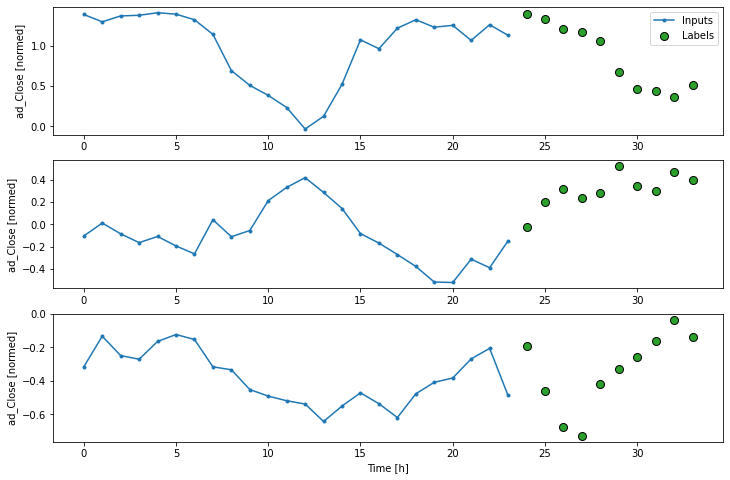

In [24]:
OUT_STEPS = 10
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)
IPython.display.clear_output()

multi_window.plot()
multi_window

In [25]:
train_ = multi_window.train
test_ = multi_window.test
val_ = multi_window.val

In [26]:
#type(multi_window.train)

In [ ]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:multi_window.total_window_size]),
                           np.array(train_df[100:100+multi_window.total_window_size]),
                           np.array(train_df[200:200+multi_window.total_window_size])])


In [56]:
last_window = tf.stack([np.array(train_df[- multi_window.total_window_size:])])

## - baseline

In [27]:
#inputs_test.numpy().mean()

7/7 [==============================] - 0s 5ms/step - loss: 0.9301 - mean_absolute_error: 0.6073


2022-04-28 12:58:15.638590: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-28 12:58:15.793828: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


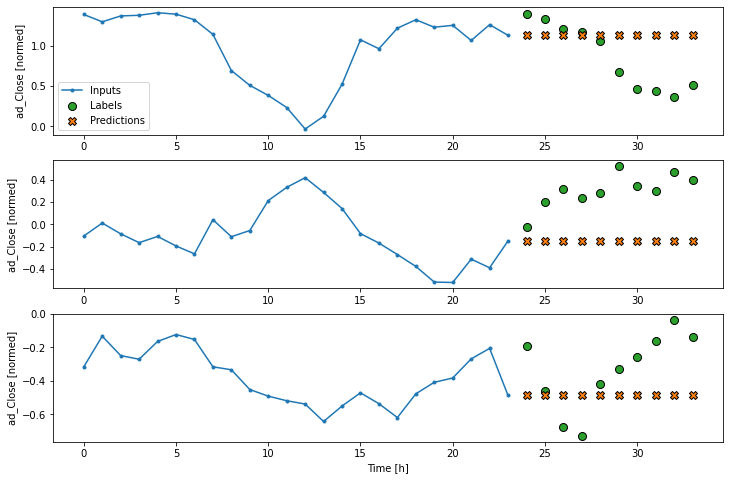

In [28]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

#inputs, labels = separe_map(multi_window)
#inputs, labels = multi_window.separe_map
#multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_val_performance['Last'] = last_baseline.evaluate(val_)
#multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_performance['Last'] = last_baseline.evaluate(test_, verbose=0)
multi_window.plot(last_baseline)

## - linear

7/7 [==============================] - 0s 1ms/step - loss: 0.3928 - root_mean_squared_error: 0.6279


2022-04-28 12:58:18.392228: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


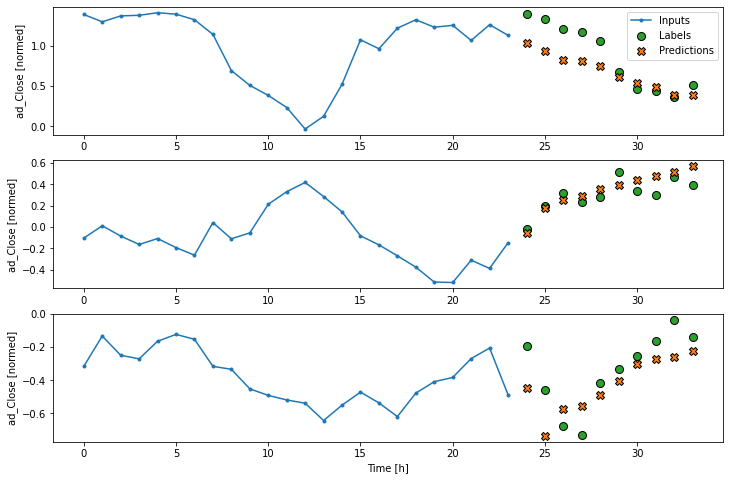

In [29]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    #tf.keras.layers.Normalization(mean=1.3008788e-06, variance=0.989949),   # including normalization
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    #tf.keras.layers.Normalization(),#,mean=1.3008788e-06, variance=0.989949),
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer='uniform'), #tf.initializers.zeros()
    #tf.keras.layers.Normalization(),
    # Shape => [batch, out_steps, features]
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])
with tf.device('/cpu:0'):
    history = compile_and_fit(multi_linear_model, multi_window)
    #inputs, labels = multi_window.separe_map

    IPython.display.clear_output()
    #multi_val_performance['Linear'] = multi_linear_model.evaluate(inputs_example, labels_example)
    multi_val_performance['Linear'] = multi_linear_model.evaluate(val_)
    multi_performance['Linear'] = multi_linear_model.evaluate(test_, verbose=0)
    #multi_performance['Linear'] = multi_linear_model.evaluate(inputs_test, labels_test, verbose=0)
    multi_window.plot(multi_linear_model)

In [30]:
multi_linear_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 1, 50)             0         
                                                                 
 dense (Dense)               (None, 1, 500)            25500     
                                                                 
 reshape (Reshape)           (None, 10, 50)            0         
                                                                 
Total params: 25,500
Trainable params: 25,500
Non-trainable params: 0
_________________________________________________________________


In [31]:
#y_train = multi_linear_model.evaluate(multi_window.train)
#y_test = multi_linear_model.evaluate(multi_window.val)

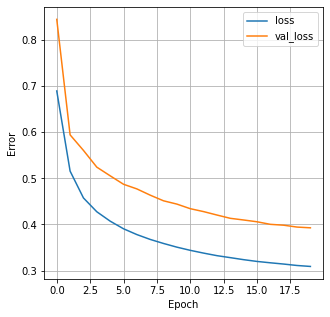

In [32]:
plot_loss(history)

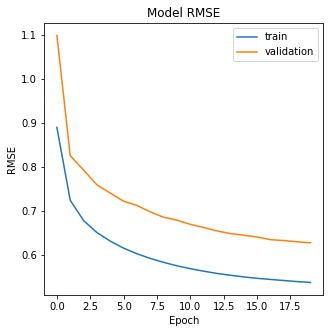

In [33]:
plot_metric(history)

In [34]:
hist_lin = pd.DataFrame(history.history)
hist_lin

,loss,root_mean_squared_error,val_loss,val_root_mean_squared_error
0,0.689097,0.890369,0.844134,1.099753
1,0.515521,0.724611,0.594053,0.825898
2,0.457450,0.678418,0.560381,0.793447
3,0.427561,0.651059,0.524147,0.759644
4,0.407238,0.631629,0.505413,0.741011
5,0.390734,0.615631,0.487098,0.722508
6,0.378170,0.602883,0.477059,0.712786
7,0.367659,0.592226,0.463507,0.698109
8,0.358887,0.583358,0.451246,0.685937
9,0.350925,0.575483,0.444143,0.679267


In [35]:
train_

<MapDataset element_spec=(TensorSpec(shape=(None, 24, 50), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10, 50), dtype=tf.float32, name=None))>

In [36]:
pred_train = multi_linear_model.predict(train_)

2022-04-28 12:58:19.035482: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [37]:
len(pred_train)

785

In [38]:
len(pred_train[0])

10

In [39]:
pred_train[0]

array([[ 0.202,  0.136,  0.185,  0.163, -0.963, -0.287,  0.227,  0.057,
         0.121,  0.155, -0.198, -0.11 ,  1.139,  0.232,  0.042,  0.189,
         0.193, -0.198,  0.012,  1.249,  0.177, -0.005,  0.112,  0.144,
        -0.221, -0.253,  1.184,  0.268,  0.083,  0.189,  0.217, -0.183,
         0.253,  1.248, -1.214, -1.064,  0.515, -0.346,  0.894,  0.712,
         0.698,  0.956, -0.798, -0.725, -0.812, -0.11 ,  0.734,  0.859,
         0.803, -0.302],
       [ 0.089, -0.012,  0.074, -0.047, -0.814, -0.207,  0.14 ,  0.064,
        -0.055, -0.036, -0.2  , -0.034,  0.442,  0.201,  0.071,  0.062,
         0.077, -0.205,  0.159,  0.842,  0.155,  0.035, -0.019, -0.006,
        -0.218,  0.212,  0.617,  0.192,  0.099,  0.046,  0.071, -0.195,
         0.225,  0.685, -0.941, -1.208,  0.126, -0.814,  0.766,  0.343,
         0.765,  0.973, -0.799, -0.756, -0.788,  0.193,  0.959,  0.615,
         0.829, -0.343],
       [-0.053, -0.089, -0.067, -0.08 , -0.858, -0.267, -0.036,  0.078,
        -0.124

In [40]:
df_pred_train = pd.DataFrame(scaler.inverse_transform(pred_train[0]))
df_pred_train.columns = train_df.columns
df_pred_train

,ad_Open,ad_High,ad_Low,ad_Close,ad_Volume,ad_Target,ad_Close_lag1,ad_Close_sma10,logprice_ad_Close,detrend_ad_Close,...,macd_s,Day,Month,week,Volatility_week,Day_sin,Month_sin,Month_cos,Year_sin,Year_cos
0,6958.713867,6974.065918,6903.171875,6940.006348,3553655.00,-0.003792,6972.447266,6883.250000,8.839326,6936.250977,...,57.160561,24.346571,3.670886,15.422756,1.340350,-6.508430e-12,0.522519,0.621245,0.646107,-0.256929
1,6901.462891,6898.824707,6846.825195,6833.684570,3948705.50,-0.002704,6928.307617,6886.761719,8.826223,6839.333496,...,62.660275,24.494938,3.667972,14.962002,1.376847,-5.233680e-12,0.682685,0.449307,0.664935,-0.285848
2,6828.977539,6859.831543,6775.532715,6816.628418,3832515.00,-0.003518,6838.995605,6893.541016,8.821135,6819.974121,...,60.777500,21.227346,3.742661,15.579394,1.532214,-6.087921e-12,0.750903,0.232371,0.616497,-0.298983
3,6805.326660,6829.250977,6760.882812,6783.156250,3922084.75,-0.003294,6808.031250,6884.471680,8.817212,6781.590332,...,57.675922,20.837860,3.827156,16.372047,1.731716,-7.119843e-12,0.740087,0.045647,0.627591,-0.333112
4,6770.466309,6812.640137,6738.941895,6748.587891,4065125.00,-0.002899,6787.681641,6869.749512,8.814424,6757.903320,...,53.045715,18.608297,4.002193,16.371870,1.966587,-6.927677e-12,0.616597,-0.165262,0.625057,-0.331571
5,6737.824219,6792.750488,6695.799805,6743.213379,4422526.50,-0.001216,6753.250488,6850.953613,8.808734,6745.927734,...,47.850368,18.083908,4.151085,16.296597,2.092404,-6.582258e-12,0.467955,-0.415205,0.623797,-0.382548
6,6723.655273,6772.188965,6692.034180,6713.709473,4844772.00,-0.000365,6735.539062,6838.958496,8.806604,6709.297363,...,39.427807,16.542723,4.237037,16.536983,2.086853,-5.659120e-12,0.385083,-0.599373,0.575198,-0.399524
7,6709.179199,6751.033691,6661.808105,6691.382324,4953456.50,0.000893,6717.437988,6824.980957,8.804385,6686.043945,...,32.231388,12.086039,4.398089,16.771013,2.160949,-6.942048e-12,0.167657,-0.692707,0.612896,-0.403876
8,6695.874023,6739.544922,6650.808594,6672.152344,4820623.00,-0.000122,6694.959473,6783.712891,8.801826,6672.447754,...,27.188065,11.055501,4.474957,16.992887,2.282294,-7.127156e-12,-0.064663,-0.688422,0.578887,-0.449148
9,6695.451172,6741.532227,6637.188965,6675.010254,4912320.50,0.000389,6671.489746,6744.897461,8.800254,6681.667480,...,18.050808,10.982429,4.508100,16.759195,2.387818,-6.872119e-12,-0.274208,-0.593970,0.575363,-0.461297


In [57]:
last_inputs, last_labels = multi_window.split_window(last_window)

In [58]:
len(last_labels)

1

In [62]:
#df_train2 = pd.DataFrame(scaler.inverse_transform(last_labels[0]))
df_train2 = pd.DataFrame(last_labels[0])
df_train2.columns = train_df.columns
df_train2

,ad_Open,ad_High,ad_Low,ad_Close,ad_Volume,ad_Target,ad_Close_lag1,ad_Close_sma10,logprice_ad_Close,detrend_ad_Close,...,macd_s,Day,Month,week,Volatility_week,Day_sin,Month_sin,Month_cos,Year_sin,Year_cos
0,6880.0,7057.0,6843.0,7021.0,7290400.0,-0.008209,6700.0,6981.7,8.856661,7021.0,...,104.976320,16.0,6.0,25.0,6.038287,-2.858239e-12,-0.664757,0.747060,0.267579,-0.963536
1,7000.0,7005.0,6905.0,6944.0,4736800.0,-0.005227,7021.0,6984.6,8.845633,6944.0,...,104.026364,17.0,6.0,25.0,6.038287,-1.311162e-11,-0.497399,0.867522,0.250964,-0.967996
2,6880.0,6940.0,6843.0,6887.0,3505100.0,-0.004817,6944.0,6975.9,8.837391,6887.0,...,101.544165,18.0,6.0,25.0,6.038287,-8.813077e-12,-0.308892,0.951097,0.234276,-0.972170
3,6908.0,6912.0,6825.0,6851.0,5820300.0,0.011440,6887.0,6954.3,8.832150,6851.0,...,97.425908,19.0,6.0,25.0,6.038287,-4.514538e-12,-0.107251,0.994232,0.217518,-0.976056
4,6799.0,6870.0,6780.0,6818.0,2826600.0,0.011746,6851.0,6919.4,8.827321,6818.0,...,91.749539,22.0,6.0,26.0,3.709255,-6.170837e-12,0.490142,0.871642,0.166878,-0.985978
5,6882.0,6969.0,6827.0,6896.0,5140000.0,-0.026086,6818.0,6896.9,8.838697,6896.0,...,86.429468,23.0,6.0,26.0,3.709255,-1.872299e-12,0.658499,0.752581,0.149893,-0.988702
6,6896.0,7012.0,6895.0,6977.0,5210200.0,0.010743,6896.0,6885.2,8.850374,6977.0,...,82.706922,24.0,6.0,26.0,3.709255,-1.212568e-11,0.798857,0.601520,0.132863,-0.991134
7,6877.0,6888.0,6793.0,6795.0,5982900.0,-0.015871,6977.0,6874.2,8.823942,6795.0,...,77.088607,25.0,6.0,26.0,3.709255,-7.827137e-12,0.905248,0.424883,0.115794,-0.993273
8,6823.0,6904.0,6821.0,6868.0,4702600.0,0.000444,6795.0,6875.7,8.834628,6868.0,...,71.565553,26.0,6.0,26.0,3.709255,-3.528598e-12,0.973148,0.230180,0.098691,-0.995118
9,6780.0,6807.0,6737.0,6759.0,5100800.0,-0.015676,6868.0,6881.6,8.818630,6759.0,...,64.489592,29.0,6.0,27.0,3.135718,-5.184897e-12,0.925876,-0.377827,0.047226,-0.998884


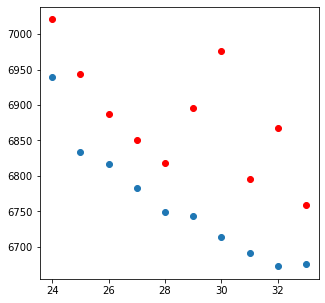

In [64]:
# plot
#df_pred_train.ad_Close
#df_train2.ad_Close
plt.scatter(multi_window.label_indices, df_pred_train.ad_Close)
plt.scatter(multi_window.label_indices, df_train2.ad_Close, color = 'red')

## - lstm

7/7 [==============================] - 0s 2ms/step - loss: 0.6389 - root_mean_squared_error: 0.9150


2022-04-28 12:58:24.633913: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


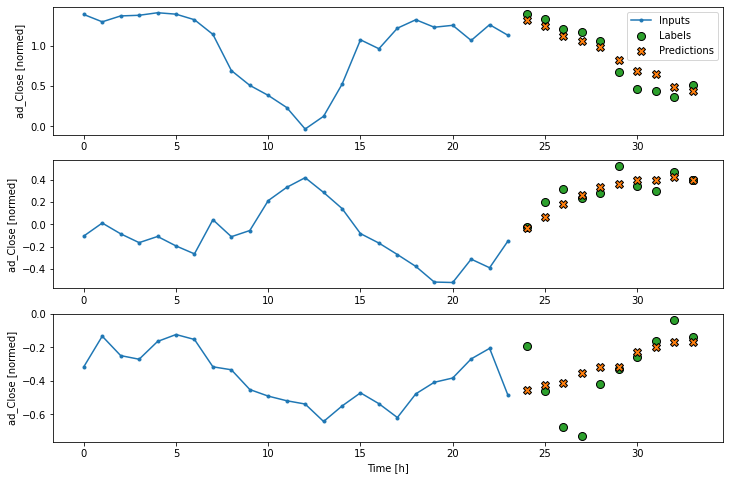

In [41]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    #tf.keras.layers.Normalization(axis=None), #added
    #tf.keras.layer.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer='uniform'),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])
with tf.device('/cpu:0'):
    history = compile_and_fit(multi_lstm_model, multi_window)

    IPython.display.clear_output()
    #inputs, labels = multi_window.separe_map
    multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
    multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
    multi_window.plot(multi_lstm_model)

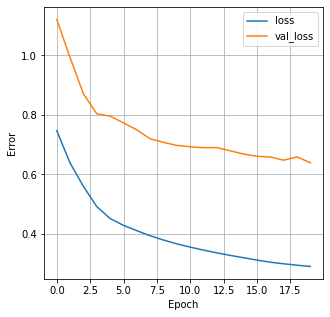

In [42]:
plot_loss(history)

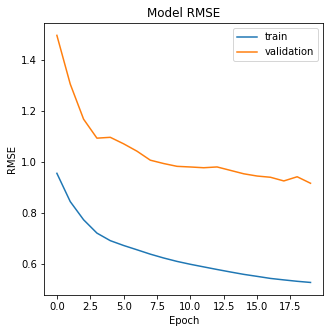

In [43]:
plot_metric(history)

In [44]:
hist_lstm = pd.DataFrame(history.history)
hist_lstm

,loss,root_mean_squared_error,val_loss,val_root_mean_squared_error
0,0.746689,0.954063,1.120836,1.495478
1,0.637810,0.843156,0.991988,1.304486
2,0.559225,0.771787,0.870292,1.166616
3,0.491462,0.719441,0.803321,1.092012
4,0.451454,0.689792,0.795651,1.095328
5,0.428534,0.670832,0.772916,1.069831
6,0.410637,0.653975,0.749438,1.040911
7,0.393533,0.636802,0.719453,1.005568
8,0.379205,0.621726,0.707418,0.992432
9,0.366291,0.608374,0.697155,0.981444
